In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import random


In [2]:
past_data = pd.ExcelFile("../../data/raw/domain/past_data.xlsx")

print("Available sheets:", past_data.sheet_names)

all_properties_df = pd.read_excel(past_data, sheet_name='All properties')

Available sheets: ['1 bedroom flat', '2 bedroom flat', '3 bedroom flat', '2 bedroom house', '3 bedroom house', '4 bedroom house', 'All properties']


In [3]:
all_properties_df.head()

,Moving annual rent by suburb,Unnamed: 1,Lease commenced in year ending,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187
0,All properties,NaN,Mar 2000,NaN,Jun 2000,NaN,Sep 2000,NaN,Dec 2000,NaN,...,Mar 2022,NaN,Jun 2022,NaN,Sep 2022,NaN,Dec 2022,NaN,Mar 2023,NaN
1,NaN,NaN,Count,Median,Count,Median,Count,Median,Count,Median,...,Count,Median,Count,Median,Count,Median,Count,Median,Count,Median
2,Inner Melbourne,Albert Park-Middle Park-West St Kilda,1143,260,1134,260,1177,270,1178,275,...,867,500,855,515,881,500,832,525,786,545
3,NaN,Armadale,733,200,737,200,738,205,739,210,...,805,430,851,450,852,450,840,460,751,490
4,NaN,Carlton North,864,260,814,260,799,265,736,270,...,581,580,535,595,547,600,546,600,490,620


In [4]:

# Function to clean the data by replacing '-' with the closest available value for each suburb
def fill_missing_with_closest(df):
    for i in range(df.shape[1]):
        column = df.iloc[:, i]
        column.replace('-', pd.NA, inplace=True)
        column.fillna(method='ffill', inplace=True)  # Forward fill
        column.fillna(method='bfill', inplace=True)  # Backward fill
    return df

# Function to convert time periods to decimals like 2000.00, 2000.25, 2000.50, and 2000.75
def convert_time_to_decimal(time_series):
    time_decimal = []
    for time in time_series:
        if pd.isna(time):
            continue
        time = str(time)
        year, month = int(time[-4:]), time[:3]
        if month == 'Mar':
            time_decimal.append(year)
        elif month == 'Jun':
            time_decimal.append(year + 0.25)
        elif month == 'Sep':
            time_decimal.append(year + 0.50)
        elif month == 'Dec':
            time_decimal.append(year + 0.75)
    return time_decimal

# Extract suburb names and relevant rent data
suburb_col = all_properties_df.iloc[2:, 1]  # Suburb names
median_rent_data = all_properties_df.iloc[2:, 84:].iloc[:, 1::2]  # Every second column starting from the 2nd one (median)


# Fill missing values
median_rent_data_cleaned = fill_missing_with_closest(median_rent_data)

# Extract the years and convert them to decimal format
time_periods = pd.Series(all_properties_df.iloc[0, 82:].iloc[::2])
time_decimal = convert_time_to_decimal(time_periods)

print(time_decimal)
# Prepare data for each suburb
suburb_rent_data = pd.DataFrame()

for i, suburb in enumerate(suburb_col):
    rents = median_rent_data_cleaned.iloc[i].dropna().astype(float).values
    years = time_decimal[:len(rents)]
    if len(rents) == len(years):  # Only include matching year-rent pairs
        temp_df = pd.DataFrame({'suburb': suburb, 'year': years, 'median_rent': rents})
        suburb_rent_data = pd.concat([suburb_rent_data, temp_df], ignore_index=True)

# Function to fit a linear model and predict growth
def fit_linear_model(suburb_data):
    X = suburb_data['year'].values.reshape(-1, 1)
    y = suburb_data['median_rent'].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Annual growth rate is the coefficient of the year
    growth_rate = model.coef_[0]
    
    # Predict prices for 2024, 2025, and 2026
    future_years = np.array([2024, 2025, 2026]).reshape(-1, 1)
    future_prices = model.predict(future_years)
    
    return growth_rate, future_prices

# Apply the function to each suburb
results = []
for suburb in suburb_rent_data['suburb'].unique():
    suburb_data = suburb_rent_data[suburb_rent_data['suburb'] == suburb]
    growth_rate, future_prices = fit_linear_model(suburb_data)
    
    # Append the result for this suburb
    results.append([suburb, growth_rate, *future_prices])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['suburb', 'annual growth rate', '2024 price', '2025 price', '2026 price'])

# Save the result to a CSV file
results_df.to_csv('../../data/curated/suburb_rent_growth_predictions.csv', index=False)


[2010, 2010.25, 2010.5, 2010.75, 2011, 2011.25, 2011.5, 2011.75, 2012, 2012.25, 2012.5, 2012.75, 2013, 2013.25, 2013.5, 2013.75, 2014, 2014.25, 2014.5, 2014.75, 2015, 2015.25, 2015.5, 2015.75, 2016, 2016.25, 2016.5, 2016.75, 2017, 2017.25, 2017.5, 2017.75, 2018, 2018.25, 2018.5, 2018.75, 2019, 2019.25, 2019.5, 2019.75, 2020, 2020.25, 2020.5, 2020.75, 2021, 2021.25, 2021.5, 2021.75, 2022, 2022.25, 2022.5, 2022.75, 2023]


/tmp/ipykernel_173850/3886256242.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='ffill', inplace=True)  # Forward fill
/tmp/ipykernel_173850/3886256242.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  column.fillna(method='ffill', inplace=True)  # Forward fill
/tmp/ipykernel_173850/3886256242.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='bfill', inplace=True)  # Backward fill


In [5]:
# Save the result to a CSV file
results_df.to_csv('../../data/curated/suburb_rent_growth_predictions.csv', index=False)


In [6]:
# Function to fit a linear model and predict dynamic growth rates
def calculate_dynamic_growth(suburb_data):
    years = suburb_data['year'].values
    rents = suburb_data['median_rent'].values
    
    # Calculate the year-on-year percentage growth
    dynamic_growth_rates = []
    for i in range(1, len(rents)):
        growth_rate = ((rents[i] - rents[i-1]) / rents[i-1]) * 100
        dynamic_growth_rates.append(growth_rate)
    
    # Calculate the average of the dynamic growth rates
    dynamic_growth_rates_cleaned = [rate for rate in dynamic_growth_rates if rate is not None]
    average_dynamic_growth_rate = np.mean(dynamic_growth_rates_cleaned)
    
    # Predict prices for 2024, 2025, 2026 using the linear model
    X = suburb_data['year'].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, rents)
    
    future_years = np.array([2024, 2025, 2026]).reshape(-1, 1)
    future_prices = model.predict(future_years)
    
    return average_dynamic_growth_rate, future_prices

# Prepare data for each suburb
results = []
for suburb in suburb_rent_data['suburb'].unique():
    suburb_data = suburb_rent_data[suburb_rent_data['suburb'] == suburb]
    average_dynamic_growth_rate, future_prices = calculate_dynamic_growth(suburb_data)
    
    # Append the result for this suburb (using the average dynamic growth rate)
    results.append([suburb, average_dynamic_growth_rate, *future_prices])

# Create a DataFrame from the results
dynamic_results_df = pd.DataFrame(results, columns=['suburb', 'average dynamic growth rate', '2024 price', '2025 price', '2026 price'])

# Save the result to a CSV file
dynamic_results_df.to_csv('../../data/curated/suburb_dynamic_growth_predictions.csv', index=False)


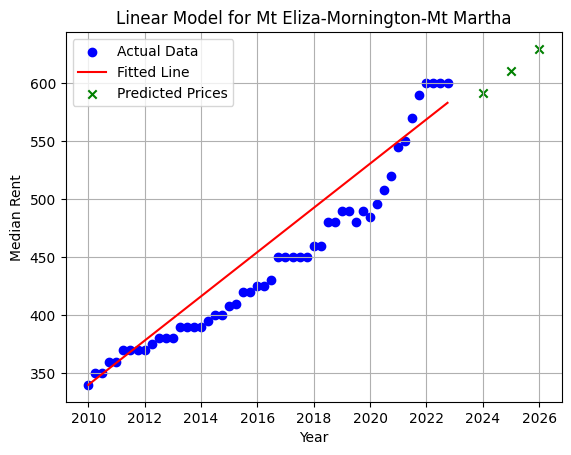

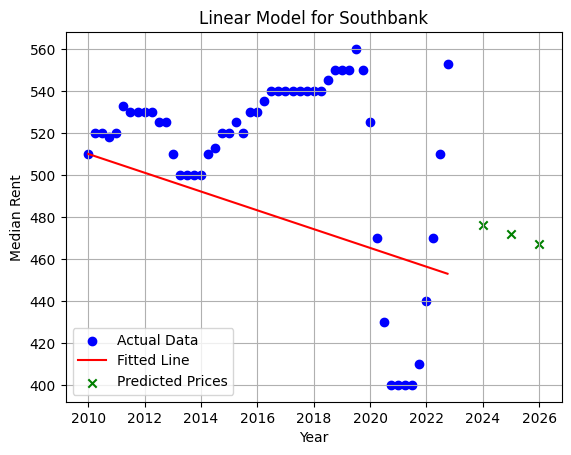

In [11]:
# Function to plot linear model for a specific suburb
def plot_linear_model(suburb_data, growth_rate, future_prices, suburb_name):
    X = suburb_data['year'].values
    y = suburb_data['median_rent'].values
    
    # Scatter plot of the actual data points
    plt.scatter(X, y, color='blue', label='Actual Data')
    
    # Plot the fitted line
    plt.plot(X, growth_rate * X + (y[0] - growth_rate * X[0]), color='red', label='Fitted Line')
    
    # Plot future predictions
    future_years = np.array([2024, 2025, 2026])
    plt.scatter(future_years, future_prices, color='green', label='Predicted Prices', marker='x')
    
    # Label the graph
    plt.title(f'Linear Model for {suburb_name}')
    plt.xlabel('Year')
    plt.ylabel('Median Rent')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sort suburbs by growth rate
sorted_suburbs = results_df.sort_values(by='annual growth rate')

# Select the suburb with the highest and lowest growth rates
highest_growth_suburb = sorted_suburbs.iloc[-1]  # Last row for highest growth
lowest_growth_suburb = sorted_suburbs.iloc[0]    # First row for lowest growth

# Plot linear model for the highest growth suburb
suburb_data_high = suburb_rent_data[suburb_rent_data['suburb'] == highest_growth_suburb['suburb']]
growth_rate_high, future_prices_high = fit_linear_model(suburb_data_high)
plot_linear_model(suburb_data_high, growth_rate_high, future_prices_high, highest_growth_suburb['suburb'])

# Plot linear model for the lowest growth suburb
suburb_data_low = suburb_rent_data[suburb_rent_data['suburb'] == lowest_growth_suburb['suburb']]
growth_rate_low, future_prices_low = fit_linear_model(suburb_data_low)
plot_linear_model(suburb_data_low, growth_rate_low, future_prices_low, lowest_growth_suburb['suburb'])
